In [9]:
# code saving the event times in an excel file 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Directory where CSV files are located
directory_path = r'H:\Magdalena\photometry\video_analysis_frames\escape_NA_Mar_2025'

# List of behavior columns in your dataset
behavior_columns = ['background', 'vonFrey', 'soundON'] 

# Function to process each CSV file
def process_csv_file(data_path):
    data = pd.read_csv(data_path)
    behavior_events = []

    for col in behavior_columns:
        # Check if the column exists in the DataFrame
        if col not in data.columns:
            print(f"Warning: Column '{col}' not found in {data_path}. Skipping this column.")
            continue

        onset_indices = data.index[data[col].diff() == 1].tolist()
        offset_indices = data.index[data[col].diff() == -1].tolist()

        if data[col].iloc[0] == 1:
            onset_indices = [0] + onset_indices
        if data[col].iloc[-1] == 1:
            offset_indices = offset_indices + [data.index[-1]]

        for start, end in zip(onset_indices, offset_indices):
            behavior_events.append({
                'Behavior': col,
                'Onset': start,
                'Offset': end
            })

    if behavior_events:  # Check if there are any events to save
        behavior_events_df = pd.DataFrame(behavior_events)
        base_name = os.path.splitext(data_path)[0]
        output_path = f'{base_name}_events.csv'
        behavior_events_df.to_csv(output_path, index=False)
        print(f'Behavior events saved to {output_path}')
    else:
        print(f"No behavior events found in {data_path}. No file created.")

    behavior_events_df = pd.DataFrame(behavior_events)
    base_name = os.path.splitext(data_path)[0]
    output_path = f'{base_name}_events.csv'
    behavior_events_df.to_csv(output_path, index=False)

# Search for all CSV files in the directory and its subdirectories
csv_files = glob.glob(f'{directory_path}/**/*.csv', recursive=True)

# Process each CSV file found
# Process each CSV file found, ignoring files that end with '_events.csv'
for file_path in csv_files:
    if not file_path.endswith('_events.csv'):
        process_csv_file(file_path)


Behavior events saved to H:\Magdalena\photometry\video_analysis_frames\escape_NA_Mar_2025\sham\C431M3_escape_labels_events.csv


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from data_import import import_ppd
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy.ndimage import uniform_filter1d
import openpyxl 

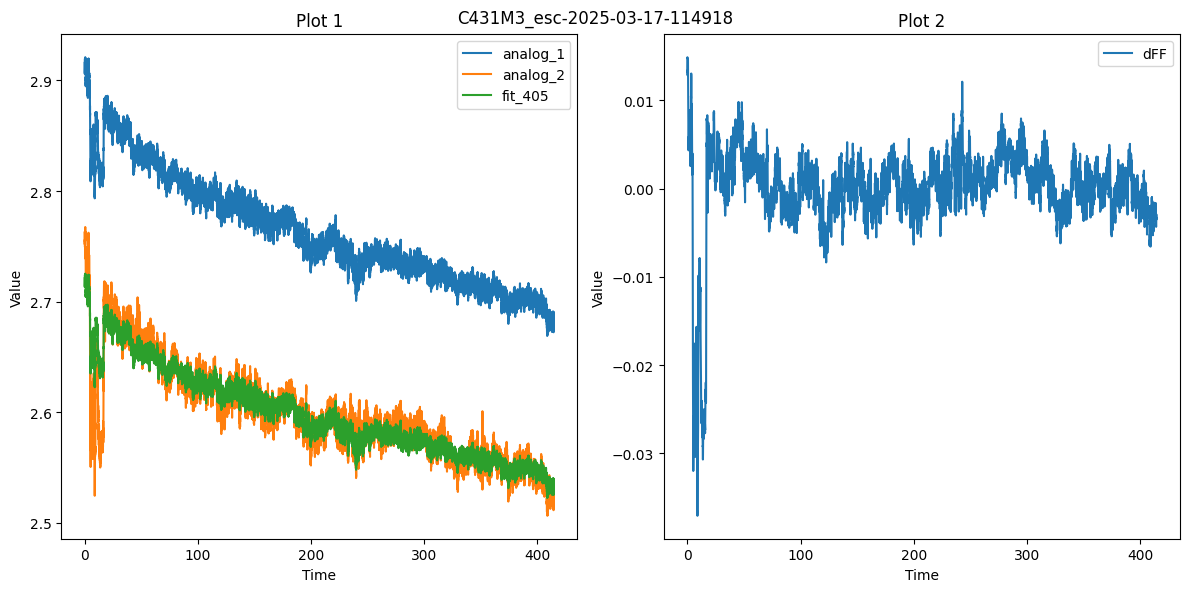

index: (array([ 4157,  4357, 28302, 28501, 36988, 37187]),)


In [11]:
# Define the PPD file path

#first NA escape batch

ppd_file_path = r'H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C431M3_esc-2025-03-17-114918.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 100                               # consider reanalizing the data because here the denominator was 130 and not 100

"""
# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
"""

# dFF calculation                      # swapping analog_1 and analog_2 because in the escape behavior recording on 20250317 and 20250318 I had the LEDs plugged in the wrong way (swapped)
reg = np.polyfit(data['analog_1'], data['analog_2'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405 = reg[0] * data['analog_1'] + reg[1]
dFF = (data['analog_2'] - fit_405) / fit_405 #this gives deltaF/F

#Function to apply smoothing to the data
def smooth_trace(trace, window_size):
    return uniform_filter1d(trace, size=window_size)
dFF = smooth_trace(dFF, 10)

data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()
# changing the plot range
# ax2.set_xlim([1200,1230])
# ax2.set_ylim([-0.02,0.03])

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.pdf')
fig.savefig(save_path, format='pdf', dpi=300)

# Display the plots
plt.show()


# Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

# Print the onsets and offsets
print("index:", index)

dFF = dFF[index[0][0]:]


In [12]:
# Load the Excel file
file_path = r'H:\Magdalena\photometry\video_analysis_frames\escape_NA_Mar_2025\sham\C431M3_log.xlsx'

excel_data = pd.read_excel(file_path)

# Extract the stimulus (Stim) value from the 'Event' column
excel_data['Stim'] = excel_data['Event'].apply(lambda x: int(x.split(':')[0]))


# Subtract 'ledonset' from the 'Frame' column and convert to string
ledonset = 1779 # for mouse C431M3


fps = 30   # change this if needed
excel_data['Time'] = ((excel_data['Frame'] - ledonset) / fps).astype(str)

# Organize data into a dictionary
data = {
    'Mouse': {
        'Stim': excel_data['Stim'].tolist(),
        'Time': excel_data['Time'].tolist()
    }
}

# Use `data` as needed in your analysis

stim_data = data['Mouse']['Stim']
time_stamps = data['Mouse']['Time']
sampling_rate = 100
fps = 30

vonFrey_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
soundON_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

vonFrey_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in vonFrey_indexes]
soundON_data_indexes = [round(float(time_stamps[i]) * sampling_rate) for i in soundON_indexes]

trace_duration = 5  # 5 seconds before and 30 seconds after each data index

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Function to analyze and plot data for different index sets
def analyze_and_plot(indexes, dFF, sampling_rate, pre_start=5, post_start=20):    # post start indicates how long the plotted trace is going to be
    trace_data_matrix = []

    for index in indexes:
        start = int(index - pre_start * sampling_rate)
        end = int(index + post_start * sampling_rate)
        if start<0 or end>len(dFF): # Skip if trace goes out of bounds
             continue
        trace_data = dFF[start:end]
        time = np.arange(start, end) / sampling_rate

        # Calculate the baseline value
        baseline_start = int(index - 5 * sampling_rate)
        baseline_end = int(index - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])

        # Compute the relative trace data
        relative_trace_data = trace_data - baseline

        # Append relative_trace_data to the matrix
        trace_data_matrix.append(relative_trace_data)


    return np.array(trace_data_matrix)


# Example usage for each data index set
trace_data_matrix_vonFrey = analyze_and_plot(vonFrey_data_indexes, dFF, sampling_rate)
trace_data_matrix_soundON = analyze_and_plot(soundON_data_indexes, dFF, sampling_rate)


In [ ]:

# Create the time vector for the first row
pre_start = 5
post_start = 20
sampling_rate = 100  # Replace with your actual sampling rate
time_vector = np.arange(-pre_start, post_start, 1/sampling_rate)

# Convert trace data to DataFrame and add time vector as the first row

df_vonFrey= pd.DataFrame(trace_data_matrix_vonFrey) 
df_soundON= pd.DataFrame(trace_data_matrix_soundON)

df_vonFrey.loc[-1] = time_vector  # Add time vector as the first row
df_vonFrey.index = df_vonFrey.index + 1  # Shift index
df_vonFrey.sort_index(inplace=True)  # Sort index

df_soundON.loc[-1] = time_vector  # Add time vector as the first row
df_soundON.index = df_soundON.index + 1  # Shift index
df_soundON.sort_index(inplace=True)  # Sort index

mouse_number="C431M3"
ppd_file_dir = r'H:\Magdalena\photometry\fp_recordings\data in excel files\NA escape March 2025'
# Save to Excel
vonFrey_excel_path = os.path.join(ppd_file_dir, f'Mouse_{mouse_number}_vonFrey_traces.xlsx')
df_vonFrey.to_excel(vonFrey_excel_path, index=False)
soundON_excel_path = os.path.join(ppd_file_dir, f'Mouse_{mouse_number}_soundON_traces.xlsx')
df_soundON.to_excel(soundON_excel_path, index=False)

100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C429M2_esc-2025-03-17-095726.png
C429M2_esc-2025-03-17-095726 not found in LED event detection results.
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C429M3_esc-2025-03-17-102823.png
C429M3_esc-2025-03-17-102823 not found in LED event detection results.
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C431M2_esc-2025-03-17-110224.png
C431M2_esc-2025-03-17-110224 not found in LED event detection results.
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C431M3_esc-2025-03-17-114918.png


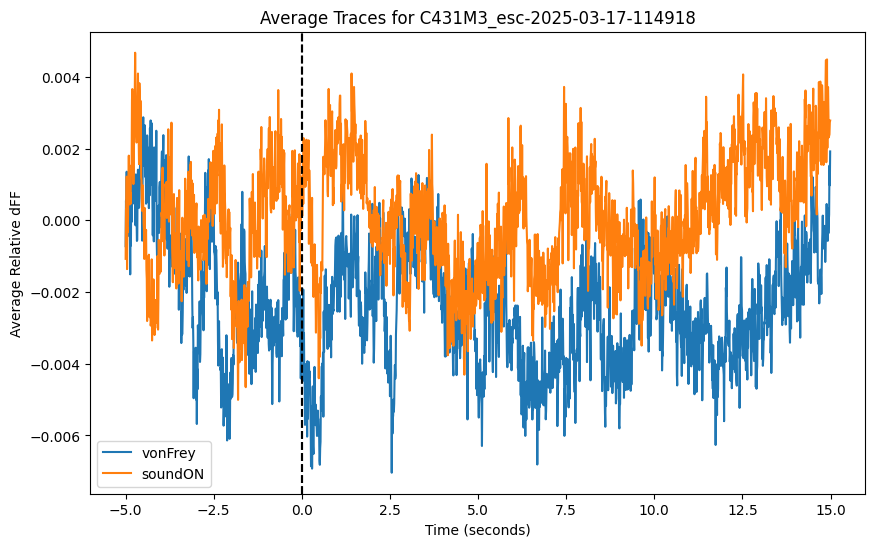

Processed and plotted average traces for: C431M3_esc-2025-03-17-114918
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C432M2_esc-2025-03-17-124441.png
C432M2_esc-2025-03-17-124441 not found in LED event detection results.
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C432M3_esc-2025-03-17-133331.png
C432M3_esc-2025-03-17-133331 not found in LED event detection results.
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C434M3_esc-2025-03-17-143058.png
C434M3_esc-2025-03-17-143058 not found in LED event detection results.
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C435M2_esc-2025-03-17-152250.png
C435M2_esc-2025-03-17-152250 not found in LED event detection results.
100
Processed and saved: H:\Magdalena\photometry\fp_recordings\escape NA March 2025\C435M3_esc-2025-03-17-170224.png
C435M3_esc-2025-03-17-170224 not found in LED event detectio

In [15]:
# average within animal

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from data_import import import_ppd  # Ensure this function is correctly implemented

# Load the LED events Excel file
led_events_path = r'H:\Magdalena\photometry\LED_Event_Detection_Results_escape_NA_March_2025.xlsx'
led_events_df = pd.read_excel(led_events_path)

# Define directories
ppd_directory_path = r'H:\Magdalena\photometry\fp_recordings\escape NA March 2025'
events_directory_path = r'H:\Magdalena\photometry\video_analysis_frames\escape_NA_Mar_2025'

pre_start = 5  # Seconds before the event
post_start = 15  # Seconds after the event

def process_behavior_trace(dFF, behavior_array, sampling_rate, ax, behavior_name):
    """
    Processes trace data for a specific behavior and plots the average trace.
    """
    num_points_per_trace = int((pre_start + post_start) * sampling_rate)
    trace_data_matrix = []
    
    for start_time in behavior_array[:, 0]:
        start = int(start_time - pre_start * sampling_rate)
        end = int(start + num_points_per_trace)
        if start < 0 or end > len(dFF):  # Skip if trace goes out of bounds
            continue
        trace_data = dFF[start:end]
        baseline_start = int(start_time - 5 * sampling_rate)
        baseline_end = int(start_time - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])
        relative_trace_data = trace_data - baseline
        trace_data_matrix.append(relative_trace_data)
    
    if trace_data_matrix:
        trace_data_matrix = np.array(trace_data_matrix)
        average_trace = np.mean(trace_data_matrix, axis=0)
        time = np.arange(-pre_start, post_start, 1 / sampling_rate)
        
        # Plot average trace for the behavior on the shared axis
        ax.plot(time, average_trace, label=behavior_name)
        plt.axvline(x=0, color='black', linestyle='--')  # Add y=0 dashed line


def process_ppd_file(ppd_file_path, led_events_df, events_directory_path):
    filename_base = os.path.splitext(os.path.basename(ppd_file_path))[0]
    data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)
    sampling_rate = data['sampling_rate']
    print(sampling_rate)
    # Convert sample index to time vector
    time = np.arange(len(data['analog_1'])) / sampling_rate
    
    # dFF calculation                      # swapping analog_1 and analog_2 because in the escape behavior recording on 20250317 and 20250318 I had the LEDs plugged in the wrong way (swapped)
    reg = np.polyfit(data['analog_1'], data['analog_2'], 1)
    fit_405 = reg[0] * data['analog_1'] + reg[1]
    dFF = (data['analog_2'] - fit_405) / fit_405

    """     # Save analog_1, analog_2, dFF to CSV
    save_data_path = os.path.join(os.path.dirname(ppd_file_path), filename_base + '_data.csv')
    df_to_save = pd.DataFrame({
        'Time': time,
        'Analog_1': data['analog_1'],
        'Analog_2': data['analog_2'],
        'dFF': dFF
    })
    df_to_save.to_csv(save_data_path, index=False)
    print(f"Data saved to: {save_data_path}") """
    
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot analog signals and fit
    ax1.plot(time, data['analog_1'], label='analog_1')
    ax1.plot(time, data['analog_2'], label='analog_2')
    ax1.plot(time, fit_405, label='fit_405')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.set_title('Analog Signals and Fit')
    ax1.legend()
    
    # Plot dFF
    ax2.plot(time, dFF, label='dFF')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('dFF')
    ax2.set_title('dFF')
    ax2.legend()
    
    plt.tight_layout()
    fig.suptitle(filename_base)
    
    # Save figure
    save_path = os.path.join(os.path.dirname(ppd_file_path), filename_base + '.png')
    fig.savefig(save_path, dpi=300)
    plt.close()  # Close the plot to save memory

    print(f"Processed and saved: {save_path}")

    row = led_events_df[led_events_df.iloc[:, 0] == filename_base]
    if row.empty:
        print(f"{filename_base} not found in LED event detection results.")
        return

    led_on = row['Onset_Point'].values[0]
    led_off = row['Offset_Point'].values[0]
    fps = row['fps'].values[0]

    events_files = glob.glob(f"{events_directory_path}/**/{filename_base}_events.csv", recursive=True)
    if not events_files:
        print(f"No matching events file found for {filename_base}.")
        return

    for events_file in events_files:
        events_data = pd.read_csv(events_file)
        events_data['Onset'] = (events_data['Onset'] - led_on) / fps * sampling_rate
        events_data['Offset'] = (events_data['Offset'] - led_on) / fps * sampling_rate

        unique_behaviors = events_data['Behavior'].unique()
        selected_behaviors = ['vonFrey', 'soundON'] 
        behavior_arrays = {}
        for behavior in selected_behaviors:
            filtered_events = events_data[events_data['Behavior'] == behavior]
            behavior_array = np.column_stack((filtered_events['Onset'].values, filtered_events['Offset'].values))
            behavior_arrays[behavior] = behavior_array

    fig, ax = plt.subplots(figsize=(10, 6))  # Shared plot for all behaviors
    
    # Process and plot each behavior on the same axes
    for behavior, behavior_array in behavior_arrays.items():
        process_behavior_trace(dFF, behavior_array, sampling_rate, ax, behavior)
    
    # Finalizing the plot
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Average Relative dFF')
    ax.set_title(f'Average Traces for {filename_base}')
    ax.legend()
    plt.show()

    print(f"Processed and plotted average traces for: {filename_base}")



# Process each .ppd file found in the directory
for ppd_file_path in glob.glob(os.path.join(ppd_directory_path, '**', '*.ppd'), recursive=True):
    process_ppd_file(ppd_file_path, led_events_df, events_directory_path)


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import resample
from numpy.typing import NDArray
from data_import import import_ppd  # Ensure this function is correctly implemented

# Load the LED events Excel file
led_events_path = r'H:\Magdalena\photometry\LED_Event_Detection_Results_LDB_NA_Jan_2025.xlsx'
led_events_df = pd.read_excel(led_events_path)

sampling_rate = 100
target_sampling_rate = 100  # Hz
pre_start = 5  # Seconds before the event
post_start = 15  # Seconds after the event
behavior_trace_data = {}  # Dictionary to store behavior trace data


def process_behavior_trace(dFF, behavior_array, sampling_rate, behavior_name):
    """
    Processes trace data for a specific behavior and stores individual traces.
    """
    num_points_per_trace = int((pre_start + post_start) * sampling_rate)
    
    for start_time in behavior_array[:, 0]:
        start = int(start_time - pre_start * sampling_rate)
        end = int(start + num_points_per_trace)
        if start < 0 or end > len(dFF):  # Skip if trace goes out of bounds
            continue
        trace_data = dFF[start:end]
        baseline_start = int(start_time - 5 * sampling_rate)
        baseline_end = int(start_time - 3 * sampling_rate)
        baseline = np.mean(dFF[baseline_start:baseline_end])
        relative_trace_data = trace_data - baseline
        
        # Store individual traces in the behavior_trace_data dictionary
        if behavior_name not in behavior_trace_data:
            behavior_trace_data[behavior_name] = [relative_trace_data]
        else:
            behavior_trace_data[behavior_name].append(relative_trace_data)


def process_group(ppd_directory_path, events_directory_path):
    global behavior_trace_data
    behavior_trace_data = {}  # Reset for each group

    # Process each .ppd file in the directory for the current group
    for ppd_file_path in glob.glob(os.path.join(ppd_directory_path, '**', '*.ppd'), recursive=True):
        process_ppd_file(ppd_file_path, led_events_df, events_directory_path)
    
    # Prepare data for plotting with trial numbers
    group_data = {}
    for behavior, individual_traces in behavior_trace_data.items():
        pooled_traces = np.stack(individual_traces, axis=0)
        average_trace = np.mean(pooled_traces, axis=0)
        sem = np.std(pooled_traces, axis=0) / np.sqrt(pooled_traces.shape[0])
        smoothed_average_trace = savgol_filter(average_trace, window_length=11, polyorder=2)
        smoothed_sem = savgol_filter(sem, window_length=11, polyorder=2)
        num_trials = len(individual_traces)  # Count the number of trials
        group_data[behavior] = (smoothed_average_trace, smoothed_sem, num_trials)
    return group_data



def process_ppd_file(ppd_file_path, led_events_df, events_directory_path):
    filename_base = os.path.splitext(os.path.basename(ppd_file_path))[0]
    data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)
    sampling_rate = data['sampling_rate']
    # Convert sample index to time vector
    time = np.arange(len(data['analog_1'])) / sampling_rate
    
    # dFF calculation
    reg = np.polyfit(data['analog_2'], data['analog_1'], 1)
    fit_405 = reg[0] * data['analog_2'] + reg[1]
    dFF = (data['analog_1'] - fit_405) / fit_405

    """     # Save analog_1, analog_2, dFF to CSV
    save_data_path = os.path.join(os.path.dirname(ppd_file_path), filename_base + '_data.csv')
    df_to_save = pd.DataFrame({
        'Time': time,
        'Analog_1': data['analog_1'],
        'Analog_2': data['analog_2'],
        'dFF': dFF
    })
    df_to_save.to_csv(save_data_path, index=False)
    print(f"Data saved to: {save_data_path}") """
    
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot analog signals and fit
    ax1.plot(time, data['analog_1'], label='analog_1')
    ax1.plot(time, data['analog_2'], label='analog_2')
    ax1.plot(time, fit_405, label='fit_405')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.set_title('Analog Signals and Fit')
    ax1.legend()
    
    # Plot dFF
    ax2.plot(time, dFF, label='dFF')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('dFF')
    ax2.set_title('dFF')
    ax2.legend()
    
    plt.tight_layout()
    fig.suptitle(filename_base)
    
    # Save figure
    save_path = os.path.join(os.path.dirname(ppd_file_path), filename_base + '.png')
    fig.savefig(save_path, dpi=300)
    plt.close()  # Close the plot to save memory

    print(f"Processed and saved: {save_path}")

    # Index of np.diff(data['digital_1']) bigger than 0.5 or smaller than -0.5
    index = np.where((np.diff(data['digital_1']) > 0.5) | (np.diff(data['digital_1']) < -0.5))

    # Print the onsets and offsets
    print("index:", index)

    dFF = dFF[index[0][0]:]

    if sampling_rate != 100:
        # Calculate the total duration of the signal in seconds
        duration = len(dFF) / sampling_rate  # Number of samples divided by the original sampling rate

        # Calculate the number of samples in the resampled signal
        num_samples_target = int(duration * target_sampling_rate)  # Duration times target sampling rate

        # Resample the data
        dFF = resample(dFF, num_samples_target)

        # Generate the new time vector for the resampled data
        time = np.linspace(0, duration, num_samples_target)

    row = led_events_df[led_events_df.iloc[:, 0] == filename_base]
    if row.empty:
        print(f"{filename_base} not found in LED event detection results.")
        return

    led_on = row['Onset_Point'].values[0]
    led_off = row['Offset_Point'].values[0]
    fps = row['fps'].values[0]

    events_files = glob.glob(f"{events_directory_path}/**/{filename_base}_events.csv", recursive=True)
    if not events_files:
        print(f"No matching events file found for {filename_base}.")
        return

    for events_file in events_files:
        events_data = pd.read_csv(events_file)
        events_data['Onset'] = (events_data['Onset'] - led_on) / fps * target_sampling_rate
        events_data['Offset'] = (events_data['Offset'] - led_on) / fps * target_sampling_rate

        unique_behaviors = events_data['Behavior'].unique()
        #unique_behaviors = ['background' 'approach' 'general' 'nose-nose' 'nose-tail' 'fight']
        selected_behaviors = ['background' 'nose-nose']
        behavior_arrays = {}
        for behavior in unique_behaviors:
            filtered_events = events_data[events_data['Behavior'] == behavior]
            behavior_array = np.column_stack((filtered_events['Onset'].values, filtered_events['Offset'].values))
            behavior_arrays[behavior] = behavior_array
    
    # Process and plot each behavior on the same axes
    for behavior, behavior_array in behavior_arrays.items():
        process_behavior_trace(dFF, behavior_array, target_sampling_rate, behavior)



ppd_directory_path = r'H:\Magdalena\photometry\fp_recordings\LDB\NA\mouse_1'
events_directory_path = r'H:\Magdalena\photometry\video_analysis_frames\LDB_NA_Jan_2025'

# Define paths for Sham and SNI groups
sham_paths = {
    'ppd_directory_path': r'H:\Magdalena\photometry\fp_recordings\LDB\NA\sham',
    'events_directory_path': r'H:\Magdalena\photometry\video_analysis_frames\LDB_NA_Jan_2025\sham'
}
sni_paths = {
    'ppd_directory_path': r'H:\Magdalena\photometry\fp_recordings\LDB\NA\SNI',
    'events_directory_path': r'H:\Magdalena\photometry\video_analysis_frames\LDB_NA_Jan_2025\SNI'
}

# Process data for both groups
sham_data = process_group(**sham_paths)
sni_data = process_group(**sni_paths)

# Determine all behaviors to plot
all_behaviors = set(sham_data.keys()).union(sni_data.keys())

# Plot data for each behavior with trial numbers in the legend
for behavior in all_behaviors:
    plt.figure(figsize=(10, 6))
    time = np.arange(-pre_start, post_start, 1 / sampling_rate)
    
    # Plot Sham data if available
    if behavior in sham_data:
        avg_trace, sem, num_trials_sham = sham_data[behavior]
        plt.plot(time, avg_trace, label=f'Sham - {behavior} (N={num_trials_sham})', color='blue')
        plt.fill_between(time, avg_trace - sem, avg_trace + sem, color='blue', alpha=0.2)
    
    # Plot SNI data if available
    if behavior in sni_data:
        avg_trace, sem, num_trials_sni = sni_data[behavior]
        plt.plot(time, avg_trace, label=f'SNI - {behavior} (N={num_trials_sni})', color='red')
        plt.fill_between(time, avg_trace - sem, avg_trace + sem, color='red', alpha=0.2)
    
    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Time (seconds)')
    plt.ylabel('dFF (%)')
    plt.ylim(-0.002, 0.003)
    plt.title(f'{behavior} - GRAB-NA-LDB Sham vs. SNI')
    plt.legend()
    plt.tight_layout()
    plt.show()



